In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata, interpn
from scipy.stats import binned_statistic
import cmocean.cm as cm
import gsw

In [2]:
# files 96 - 100 are the transect from Jan 5
# files 108 and 109 are the two casts at C2
# files 110 - 114 are the transect from Jan 7

# January 5am Microprofiles

In [3]:
# mp10 = xr.open_dataset('dat_0110.nc')
mp95 = xr.open_dataset('dat_0095.nc') # station 205
mp94 = xr.open_dataset('dat_0094.nc') # 204
mp93 = xr.open_dataset('dat_0093.nc') # 203
mp91 = xr.open_dataset('dat_0091.nc') # 201
mp90 = xr.open_dataset('dat_0090.nc') # 200

In [4]:
# sh10 = xr.open_dataset('shear0110.nc')
sh95 = xr.open_dataset('shear0095.nc')
sh94 = xr.open_dataset('shear0094.nc')
sh93 = xr.open_dataset('shear0093.nc')
sh91 = xr.open_dataset('shear0091.nc')
sh90 = xr.open_dataset('shear0090.nc')

In [5]:
lon95fast = [-72.46381for i in range(len(mp95.time_fast[0]))]
lon94fast = [-72.45491 for i in range(len(mp94.time_fast[0]))]
lon93fast = [-72.445 for i in range(len(mp93.time_fast[0]))]
lon91fast = [-72.43545 for i in range(len(mp91.time_fast[0]))]
lon90fast = [-72.42602 for i in range(len(mp90.time_fast[0]))]


lat95fast = [-42.38165 for i in range(len(mp95.time_fast[0]))]
lat94fast = [-42.38076 for i in range(len(mp94.time_fast[0]))]
lat93fast = [-42.38076 for i in range(len(mp93.time_fast[0]))]
lat91fast = [-42.37947 for i in range(len(mp91.time_fast[0]))]
lat90fast = [-42.38046 for i in range(len(mp90.time_fast[0]))]

# *transect varies most in the east-west so lets plot according to lon

In [6]:
# must just use downcast
# FastStart10 = 15000
# FastEnd10 = 190000
FastStart90 = 8000
FastEnd90 = 155000
FastStart91 = 10000
FastEnd91 = 290000
FastStart93 = 50000
FastEnd93 = 340000
FastStart94 = 25000
FastEnd94 = 250000
FastStart95 = 9000
FastEnd95 = 90000

In [87]:
lon_fast = np.append(lon90fast[FastStart90:FastEnd90],np.append(lon91fast[FastStart91:FastEnd91],np.append(lon93fast[FastStart93:FastEnd93],np.append(lon94fast[FastStart94:FastEnd94],lon95fast[FastStart95:FastEnd95]))))
lat_fast = np.append(lat90fast[FastStart90:FastEnd90],np.append(lat91fast[FastStart91:FastEnd91],np.append(lat93fast[FastStart93:FastEnd93],np.append(lat94fast[FastStart94:FastEnd94],lat95fast[FastStart95:FastEnd95]))))
pressure_fast = np.append(mp90.P_fast.values[0,FastStart90:FastEnd90],np.append(mp91.P_fast.values[0,FastStart91:FastEnd91],np.append(mp93.P_fast.values[0,FastStart93:FastEnd93],np.append(mp94.P_fast.values[0,FastStart94:FastEnd94],mp95.P_fast.values[0,FastStart95:FastEnd95]))))
chloro = np.append(mp90.chlorophyll.values[0,FastStart90:FastEnd90],np.append(mp91.chlorophyll.values[0,FastStart91:FastEnd91],np.append(mp93.chlorophyll.values[0,FastStart93:FastEnd93],np.append(mp94.chlorophyll.values[0,FastStart94:FastEnd94],mp95.chlorophyll.values[0,FastStart95:FastEnd95]))))
turb = np.append(mp90.turbidity.values[0,FastStart90:FastEnd90],np.append(mp91.turbidity.values[0,FastStart91:FastEnd91],np.append(mp93.turbidity.values[0,FastStart93:FastEnd93],np.append(mp94.turbidity.values[0,FastStart94:FastEnd94],mp95.turbidity.values[0,FastStart95:FastEnd95]))))
temp = np.append(mp90.T1.values[0,FastStart90:FastEnd90],np.append(mp91.T1.values[0,FastStart91:FastEnd91],np.append(mp93.T1.values[0,FastStart93:FastEnd93],np.append(mp94.T1.values[0,FastStart94:FastEnd94],mp95.T1.values[0,FastStart95:FastEnd95]))))
cond = np.append(mp90.C1.values[0,FastStart90:FastEnd90],np.append(mp91.C1.values[0,FastStart91:FastEnd91],np.append(mp93.C1.values[0,FastStart93:FastEnd93],np.append(mp94.C1.values[0,FastStart94:FastEnd94],mp95.C1.values[0,FastStart95:FastEnd95]))))

In [8]:
data = {'lon':lon_fast, 'lat':lat_fast, 'pressure':pressure_fast, 'chloro':chloro, 'turb':turb, 'temp':temp, 'cond':cond}
fast = pd.DataFrame(data)

In [62]:
mp93

<xarray.Dataset>
Dimensions:      (c: 1, d: 88064, e: 704512, b: 141, f: 2, h: 1, g: 141)
Dimensions without coordinates: c, d, e, b, f, h, g
Data variables: (12/17)
    time_slow    (c, d) float64 ...
    time_fast    (c, e) float64 ...
    diss_e       (b, f) float64 ...
    P_slow       (c, d) float64 ...
    P_fast       (c, e) float64 -0.08304 -0.08304 -0.08304 ... -0.1482 -0.1482
    shear1       (c, e) float64 ...
    ...           ...
    T1           (c, e) float64 19.18 19.18 19.18 19.18 ... 16.24 16.24 16.24
    grad_C1      (c, e) float64 ...
    grad_T1      (c, e) float64 ...
    JAC_T        (c, d) float64 ...
    JAC_C        (c, d) float64 ...
    P_diss       (h, g) float64 ...

In [100]:
slowSbin = np.array([binned_statistic(mp93.P_slow[0, 8000:40000], mp93.JAC_C[0, 8000:40000], statistic='mean', bins=depth_bins)[0][:] for lon in lons]).flatten()
cond_bin =np.array([binned_statistic(mp93.P_fast.values[0,FastStart93:FastEnd93], mp93.C1.values[0,FastStart93:FastEnd93], statistic='mean', bins=depth_bins)[0][:] for lon in lons]).flatten()
offset = np.nanmean(slowSbin-cond_bin)

In [104]:
fast.cond+offset

0          26.174551
1          26.181890
2          26.183898
3          26.251637
4          26.387307
             ...    
1022995    36.335980
1022996    36.336136
1022997    36.336423
1022998    36.336590
1022999    36.336477
Name: cond, Length: 1023000, dtype: float64

In [103]:
offset

1.5327121667524777

In [105]:
SP = gsw.conversions.SP_from_C(fast.cond+offset, fast.temp, fast.pressure)
fast['sali'] = gsw.conversions.SA_from_SP(np.array(SP), np.array(fast.pressure), -72.4477, -42.1646)

In [106]:
# bin by depth in 1 m intervals
depth_bins = np.arange(0,np.max(fast.pressure)+1,1)
lons = [lon90fast[0],lon91fast[0],lon93fast[0],lon94fast[0],lon95fast[0]]
lats = [lat90fast[0],lat91fast[0],lat93fast[0],lat94fast[0],lat95fast[0]]

chloro_bin =np.array([binned_statistic(fast.pressure[(fast.lon == lon)], fast.chloro[(fast.lon == lon)], statistic='mean', bins=depth_bins)[0][:] for lon in lons]).flatten()
turb_bin =np.array([binned_statistic(fast.pressure[(fast.lon == lon)], fast.turb[(fast.lon == lon)], statistic='mean', bins=depth_bins)[0][:] for lon in lons]).flatten()
temp_bin =np.array([binned_statistic(fast.pressure[(fast.lon == lon)], fast.temp[(fast.lon == lon)], statistic='mean', bins=depth_bins)[0][:] for lon in lons]).flatten()
sali_bin =np.array([binned_statistic(fast.pressure[(fast.lon == lon)], fast.sali[(fast.lon == lon)], statistic='mean', bins=depth_bins)[0][:] for lon in lons]).flatten()

pressure_bin = np.tile(depth_bins[:-1],5)
lat_bin = np.array([np.repeat(lat, len(depth_bins)-1) for lat in lats]).flatten()
lon_bin = np.array([np.repeat(lon, len(depth_bins)-1) for lon in lons]).flatten()

In [107]:
data = {'lon':lon_bin, 'lat':lat_bin, 'pressure':pressure_bin, 'chloro':chloro_bin, 'turb':turb_bin, 'temp':temp_bin, 'sali':sali_bin}
fast_bin = pd.DataFrame(data)
# fast_bin

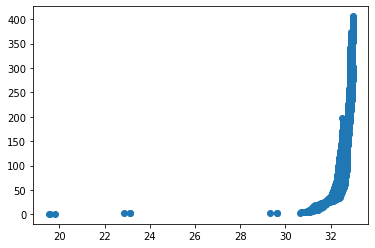

In [108]:
plt.scatter(fast_bin.sali, fast_bin.pressure)
# plt.xlim([-0.2,0.2])

In [115]:
chloro_min = 0
chloro_max = 11

shear_min = -2
shear_max = +2

turb_min = 0
turb_max = 1.2

temp_min = 10.5
temp_max = 18

sali_min = 28
sali_max = 33.5

In [116]:
lon_bins = [lon95fast[0]-0.005,np.mean([lon95fast[0],lon94fast[0]]),np.mean([lon94fast[0],lon93fast[0]]),np.mean([lon93fast[0],lon91fast[0]]),np.mean([lon91fast[0],lon90fast[0]]),lon90fast[0]+0.005]
# 31.6 32.3
lon_label = [str(lon95fast[0])[:-2]+"\nstation 205", str(lon94fast[0])[:-2]+"\nstation 204", str(lon93fast[0])[:-2]+"\nstation 203", str(lon91fast[0])[:-2]+"\nstation 201",  str(lon90fast[0])[:-2]+"\nstation 200"]
label_loc = [lon95fast[0]-0.005, lon94fast[0]-0.005, lon93fast[0]-0.005, lon91fast[0]-0.005, lon90fast[0]-0.005]

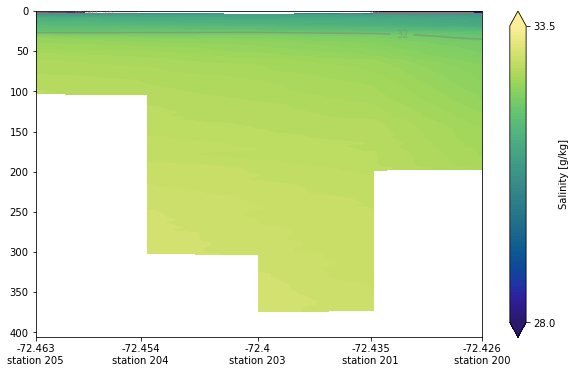

In [124]:
H_sal, xedges, yedges = np.histogram2d(fast_bin.lon, fast_bin.pressure, weights=fast_bin.sali, bins=[lon_bins,depth_bins])
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

fig, ax = plt.subplots(1,1,figsize=(10,6))
levelsf = np.linspace(sali_min,sali_max, 100)
# levels = np.linspace(sali_min,sali_max, 5)

WMlevels = [11,21,31,33,33.8,34.9]
fmt = fmt = {}
WMlabels = ['Fresh', 'EW', 'EW-Saline', 'MSAAW', 'SAAW', 'ESSW']
for l, s in zip(WMlevels, WMlabels):
    fmt[l] = s


cmap = cm.haline

im = ax.contourf(X, Y, H_sal.T,levelsf, cmap=cmap, extend='both')
cb1 = fig.colorbar(im, ticks=[sali_min,sali_max], ax=ax, label='Salinity [g/kg]')
CS= ax.contour(X, Y, H_sal.T,colors='grey', zorder=2, alpha=0.5)
ax.clabel(CS, inline=True,fontsize=10)
ax.set_xticks(label_loc)
ax.set_xticklabels(lon_label)
ax.set_xlim([lon95fast[0]-0.005,lon90fast[0]-0.005])

ax.invert_yaxis()
# ax.set_ylim([150,0]);


#g/kg

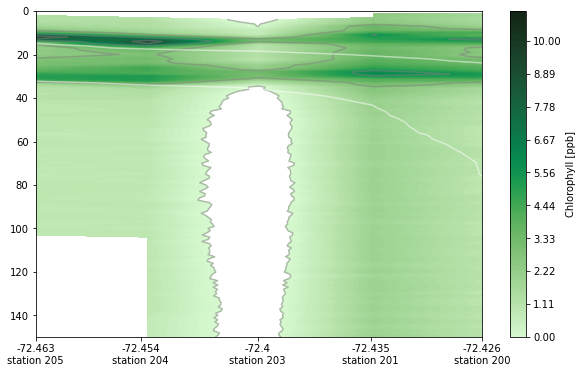

In [126]:
H, xedges, yedges = np.histogram2d(fast_bin.lon, fast_bin.pressure, weights=fast_bin.chloro, bins=[lon_bins,depth_bins])
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

fig, ax = plt.subplots(1,1,figsize=(10,6))
levelsf = np.linspace(chloro_min,chloro_max, 100)
levels = np.linspace(chloro_min,chloro_max, 5)
im = ax.contourf(X, Y, H.T,levelsf, cmap=cm.algae)
cb1 = fig.colorbar(im, ax=ax, label="Chlorophyll [ppb]")
ax.contour(X, Y, H.T,levels, colors='grey', zorder=2, alpha=0.5)
ax.contour(X, Y, H_sal.T,[31.6, 32.3], colors='white', zorder=2, alpha=0.5)


ax.set_xticks(label_loc)
ax.set_xticklabels(lon_label)
ax.set_xlim([lon95fast[0]-0.005,lon90fast[0]-0.005])

ax.invert_yaxis()
ax.set_ylim([150,0]);


# ppb

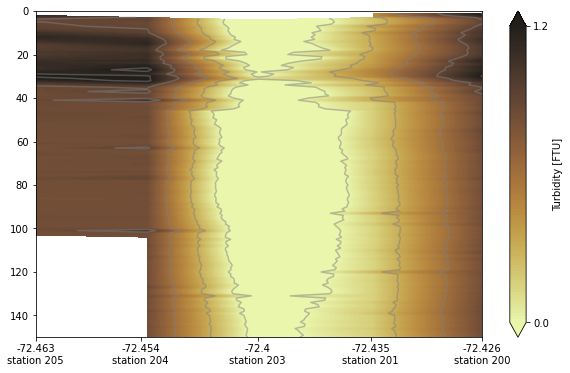

In [24]:
H, xedges, yedges = np.histogram2d(fast_bin.lon, fast_bin.pressure, weights=fast_bin.turb, bins=[lon_bins,depth_bins])
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

fig, ax = plt.subplots(1,1,figsize=(10,6))
levelsf = np.linspace(turb_min,turb_max, 100)
levels = np.linspace(turb_min,turb_max, 5)

cmap = cm.turbid

im = ax.contourf(X, Y, H.T,levelsf, cmap=cmap, extend='both')
cb1 = fig.colorbar(im, ticks=[turb_min,turb_max], ax=ax, label='Turbidity [FTU]')
ax.contour(X, Y, H.T,levels, colors='grey', zorder=2, alpha=0.5)
ax.set_xticks(label_loc)
ax.set_xticklabels(lon_label)
ax.set_xlim([lon95fast[0]-0.005,lon90fast[0]-0.005])

ax.invert_yaxis()
ax.set_ylim([150,0]);


# FTU

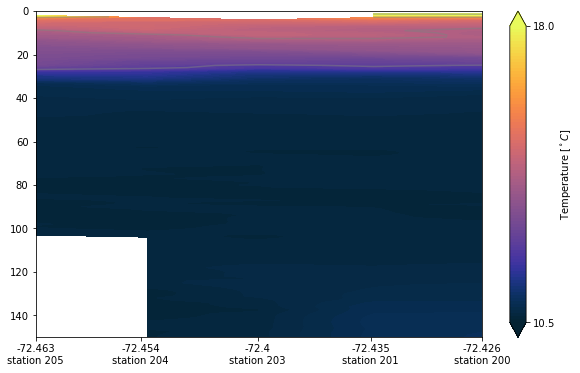

In [25]:
H, xedges, yedges = np.histogram2d(fast_bin.lon, fast_bin.pressure, weights=fast_bin.temp, bins=[lon_bins,depth_bins])
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

fig, ax = plt.subplots(1,1,figsize=(10,6))
levelsf = np.linspace(temp_min,temp_max, 100)
levels = np.linspace(temp_min,temp_max, 5)

cmap = cm.thermal

im = ax.contourf(X, Y, H.T,levelsf, cmap=cmap, extend='both')
cb1 = fig.colorbar(im, ticks=[temp_min,temp_max], ax=ax, label="Temperature [$^\circ C$]")
ax.contour(X, Y, H.T,levels, colors='grey', zorder=2, alpha=0.5)
ax.set_xticks(label_loc)
ax.set_xticklabels(lon_label)
ax.set_xlim([lon95fast[0]-0.005,lon90fast[0]-0.005])

ax.invert_yaxis()
ax.set_ylim([150,0]);


### similar analysis but with shear

In [52]:
shear1 = abs(np.append(sh90.SH_HP[0],np.append(sh91.SH_HP[0],np.append(sh93.SH_HP[0],np.append(sh94.SH_HP[0],sh95.SH_HP[0])))))
shear2 = abs(np.append(sh90.SH_HP[1],np.append(sh91.SH_HP[1],np.append(sh93.SH_HP[1],np.append(sh94.SH_HP[0],sh95.SH_HP[0])))))
Pshear = np.append(sh90.Indep_var_fast,np.append(sh91.Indep_var_fast,np.append(sh93.Indep_var_fast,np.append(sh94.Indep_var_fast,sh95.Indep_var_fast))))

In [53]:
lat_shear = np.append(np.repeat(lats[0],len(sh90.SH_HP[0])),np.append(np.repeat(lats[1],len(sh91.SH_HP[0])),np.append(np.repeat(lats[2],len(sh93.SH_HP[0])),np.append(np.repeat(lats[3],len(sh94.SH_HP[0])),np.repeat(lats[4],len(sh95.SH_HP[0]))))))
lon_shear = np.append(np.repeat(lons[0],len(sh90.SH_HP[0])),np.append(np.repeat(lons[1],len(sh91.SH_HP[0])),np.append(np.repeat(lons[2],len(sh93.SH_HP[0])),np.append(np.repeat(lons[3],len(sh94.SH_HP[0])),np.repeat(lons[4],len(sh95.SH_HP[0]))))))

In [55]:
data = {'lon':lon_shear, 'lat':lat_shear, 'pressure':Pshear, 'shear1':shear1, 'shear2':shear2}
dtShear = pd.DataFrame(data)

In [56]:
# bin by depth in 1 m intervals
depth_bins = np.arange(0,np.max(dtShear.pressure)+1,1)

shear1_bin =np.array([binned_statistic(dtShear.pressure[(dtShear.lon == lon)], dtShear.shear1[(dtShear.lon == lon)], statistic='mean', bins=depth_bins)[0][:] for lon in lons]).flatten()
shear2_bin =np.array([binned_statistic(dtShear.pressure[(dtShear.lon == lon)], dtShear.shear2[(dtShear.lon == lon)], statistic='mean', bins=depth_bins)[0][:] for lon in lons]).flatten()

pressure_bin = np.tile(depth_bins[:-1],5)
lat_bin = np.array([np.repeat(lat, len(depth_bins)-1) for lat in lats]).flatten()
lon_bin = np.array([np.repeat(lon, len(depth_bins)-1) for lon in lons]).flatten()

In [57]:
data = {'lon':lon_bin, 'lat':lat_bin, 'pressure':pressure_bin, 'shear1':shear1_bin, 'shear2':shear2_bin}
shear_bin = pd.DataFrame(data)

In [58]:
shear_min = -0.05
shear_max = 0.05

In [59]:
# H, xedges, yedges = np.histogram2d(shear_bin.lon, shear_bin.pressure, weights=shear_bin.shear1, bins=[lon_bins,depth_bins])
# X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

# fig, ax = plt.subplots(1,1,figsize=(10,6))
# levelsf = np.linspace(shear_min,shear_max, 100)
# levels = np.linspace(shear_min,shear_max, 5)

# cmap = cm.balance

# im = ax.contourf(X, Y, H.T,levelsf, cmap=cmap, extend='both')
# cb1 = fig.colorbar(im, ticks=[shear_min,0,shear_max], ax=ax)
# # ax.contour(X, Y, H.T,levels, colors='grey', zorder=2, alpha=0.5)
# ax.set_xticks(label_loc)
# ax.set_xticklabels(lon_label)
# ax.invert_yaxis()

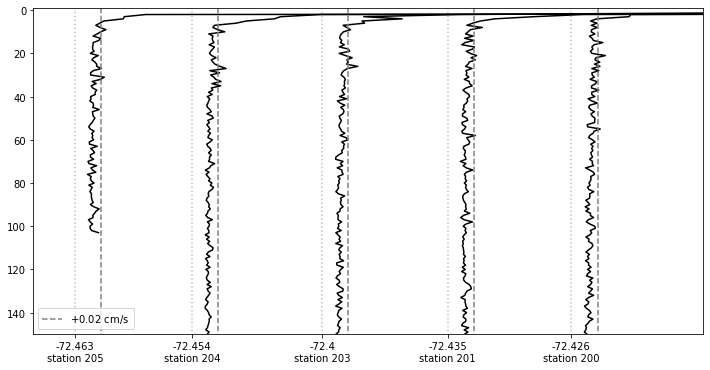

In [127]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(shear_bin.shear1[shear_bin.lon==lons[0]]+lons[0]*10, shear_bin.pressure[shear_bin.lon==lons[0]], 'k')
ax.plot(shear_bin.shear1[shear_bin.lon==lons[1]]+lons[1]*10, shear_bin.pressure[shear_bin.lon==lons[1]], 'k')
ax.plot(shear_bin.shear1[shear_bin.lon==lons[2]]+lons[2]*10, shear_bin.pressure[shear_bin.lon==lons[2]], 'k')
ax.plot(shear_bin.shear1[shear_bin.lon==lons[3]]+lons[3]*10, shear_bin.pressure[shear_bin.lon==lons[3]], 'k')
ax.plot(shear_bin.shear1[shear_bin.lon==lons[4]]+lons[4]*10, shear_bin.pressure[shear_bin.lon==lons[4]], 'k')

ax.plot([lons[0]*10,lons[0]*10],[276,-1],'grey', ls=':', alpha=0.5)
ax.plot([lons[1]*10,lons[1]*10],[276,-1],'grey', ls=':', alpha=0.5)
ax.plot([lons[2]*10,lons[2]*10],[276,-1],'grey', ls=':', alpha=0.5)
ax.plot([lons[3]*10,lons[3]*10],[276,-1],'grey', ls=':', alpha=0.5)
ax.plot([lons[4]*10,lons[4]*10],[276,-1],'grey', ls=':', alpha=0.5)

ax.plot([lons[0]*10+0.02, lons[0]*10+0.02],[276,-1],'grey',ls='--',label='$+ 0.02$ cm/s')
ax.plot([lons[1]*10+0.02, lons[1]*10+0.02],[276,-1],'grey',ls='--')
ax.plot([lons[2]*10+0.02, lons[2]*10+0.02],[276,-1],'grey',ls='--')
ax.plot([lons[3]*10+0.02, lons[3]*10+0.02],[276,-1],'grey',ls='--')
ax.plot([lons[4]*10+0.02, lons[4]*10+0.02],[276,-1],'grey',ls='--')


ax.legend(loc="lower left")
ax.set_xlim([-724.67,-724.16])
ax.set_ylim([150,-1])
ax.set_xticks([lons[i]*10 for i in [4,3,2,1,0]])
ax.set_xticklabels(lon_label);

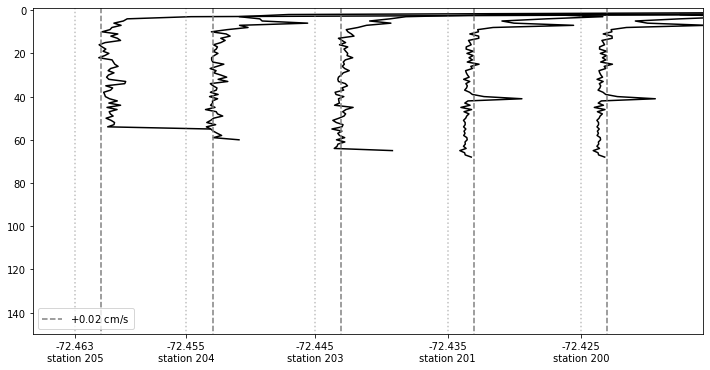

In [48]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(shear_bin.shear2[shear_bin.lon==lons[0]]+lons[0]*10, shear_bin.pressure[shear_bin.lon==lons[0]], 'k')
ax.plot(shear_bin.shear2[shear_bin.lon==lons[1]]+lons[1]*10, shear_bin.pressure[shear_bin.lon==lons[1]], 'k')
ax.plot(shear_bin.shear2[shear_bin.lon==lons[2]]+lons[2]*10, shear_bin.pressure[shear_bin.lon==lons[2]], 'k')
ax.plot(shear_bin.shear2[shear_bin.lon==lons[3]]+lons[3]*10, shear_bin.pressure[shear_bin.lon==lons[3]], 'k')
ax.plot(shear_bin.shear2[shear_bin.lon==lons[3]]+lons[4]*10, shear_bin.pressure[shear_bin.lon==lons[4]], 'k')

ax.plot([lons[0]*10,lons[0]*10],[276,-1],'grey', ls=':', alpha=0.5)
ax.plot([lons[1]*10,lons[1]*10],[276,-1],'grey', ls=':', alpha=0.5)
ax.plot([lons[2]*10,lons[2]*10],[276,-1],'grey', ls=':', alpha=0.5)
ax.plot([lons[3]*10,lons[3]*10],[276,-1],'grey', ls=':', alpha=0.5)
ax.plot([lons[4]*10,lons[4]*10],[276,-1],'grey', ls=':', alpha=0.5)

ax.plot([lons[0]*10+0.02, lons[0]*10+0.02],[276,-1],'grey',ls='--',label='$+ 0.02$ cm/s')
ax.plot([lons[1]*10+0.02, lons[1]*10+0.02],[276,-1],'grey',ls='--')
ax.plot([lons[2]*10+0.02, lons[2]*10+0.02],[276,-1],'grey',ls='--')
ax.plot([lons[3]*10+0.02, lons[3]*10+0.02],[276,-1],'grey',ls='--')
ax.plot([lons[4]*10+0.02, lons[4]*10+0.02],[276,-1],'grey',ls='--')


ax.legend(loc="lower left")
ax.set_xlim([-724.67,-724.16])
ax.set_ylim([150,-1])
ax.set_xticks([lons[i]*10 for i in [0,1,2,3,4]])
ax.set_xticklabels(lon_label);

# Dissipation

In [129]:
diss = abs(np.append(mp90.diss_e[:,0],np.append(mp91.diss_e[:,0],np.append(mp93.diss_e[:,0],np.append(mp94.diss_e[:,0],mp95.diss_e[:,0])))))
Pdiss = np.append(mp90.P_diss,np.append(mp91.P_diss,np.append(mp93.P_diss,np.append(mp94.P_diss,mp95.P_diss))))
lat_diss = np.append(np.repeat(lats[0],len(mp90.P_diss[0])),np.append(np.repeat(lats[1],len(mp91.P_diss[0])),np.append(np.repeat(lats[2],len(mp93.P_diss[0])),np.append(np.repeat(lats[3],len(mp94.P_diss[0])),np.repeat(lats[4],len(mp95.P_diss[0]))))))
lon_diss = np.append(np.repeat(lons[0],len(mp90.P_diss[0])),np.append(np.repeat(lons[1],len(mp91.P_diss[0])),np.append(np.repeat(lons[2],len(mp93.P_diss[0])),np.append(np.repeat(lons[3],len(mp94.P_diss[0])),np.repeat(lons[4],len(mp95.P_diss[0]))))))

In [130]:
data = {'lon':lon_diss, 'lat':lat_diss, 'pressure':Pdiss, 'diss':diss}
dtDiss = pd.DataFrame(data)
# dont need to bin, already done 

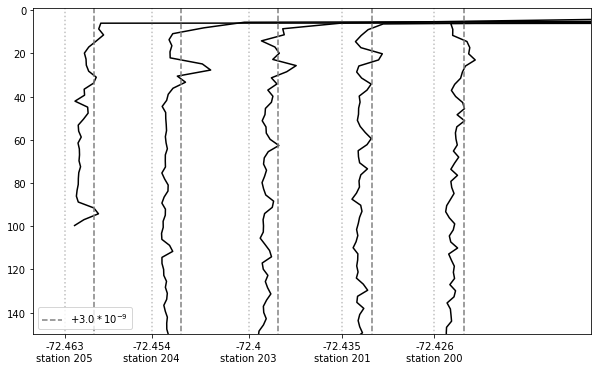

In [132]:
# prefer to see in spaced out line plot instead!

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(dtDiss.diss[dtDiss.lon==lons[0]]+lons[0]*10**-6, dtDiss.pressure[dtDiss.lon==lons[0]], 'k')
ax.plot(dtDiss.diss[dtDiss.lon==lons[1]]+lons[1]*10**-6, dtDiss.pressure[dtDiss.lon==lons[1]], 'k')
ax.plot(dtDiss.diss[dtDiss.lon==lons[2]]+lons[2]*10**-6, dtDiss.pressure[dtDiss.lon==lons[2]], 'k')
ax.plot(dtDiss.diss[dtDiss.lon==lons[3]]+lons[3]*10**-6, dtDiss.pressure[dtDiss.lon==lons[3]], 'k')
ax.plot(dtDiss.diss[dtDiss.lon==lons[4]]+lons[4]*10**-6, dtDiss.pressure[dtDiss.lon==lons[4]], 'k')

ax.plot([lons[0]*10**-6,lons[0]*10**-6],[276,-1],'grey', ls=':', alpha=0.5)
ax.plot([lons[1]*10**-6,lons[1]*10**-6],[276,-1],'grey', ls=':', alpha=0.5)
ax.plot([lons[2]*10**-6,lons[2]*10**-6],[276,-1],'grey', ls=':', alpha=0.5)
ax.plot([lons[3]*10**-6,lons[3]*10**-6],[276,-1],'grey', ls=':', alpha=0.5)
ax.plot([lons[4]*10**-6,lons[4]*10**-6],[276,-1],'grey', ls=':', alpha=0.5)

ax.plot([lons[0]*10**-6+(3e-09), lons[0]*10**-6+(3e-09)],[276,-1],'grey',ls='--',label='$+ 3.0*10^{-9}$')
ax.plot([lons[1]*10**-6+(3e-09), lons[1]*10**-6+(3e-09)],[276,-1],'grey',ls='--')
ax.plot([lons[2]*10**-6+(3e-09), lons[2]*10**-6+(3e-09)],[276,-1],'grey',ls='--')
ax.plot([lons[3]*10**-6+(3e-09), lons[3]*10**-6+(3e-09)],[276,-1],'grey',ls='--')
ax.plot([lons[4]*10**-6+(3e-09), lons[4]*10**-6+(3e-09)],[276,-1],'grey',ls='--')

ax.legend(loc="lower left")
ax.set_xlim([-0.000072467,-0.00007241])
ax.set_ylim([150,-1])
ax.set_xticks([lons[i]*10**-6 for i in [4,3,2,1,0]])
ax.set_xticklabels(lon_label);